In [3]:
import csv
import time
import re
import calendar
import sqlite3
import unicodedata
import string
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from math import ceil
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
from collections import OrderedDict

In [9]:
#Helper Classes
class DefaultListOrderedDict(OrderedDict):
    def __missing__(self,k):
        self[k] = []
        return self[k]
    
class DefaultIntOrderedDict(OrderedDict):
    def __missing__(self,k):
        self[k] = 0
        return self[k]

def week_of_month(date):
    """ 
    Returns week of the month 1:4
    """
    first_day = date.replace(day=1)
    day_of_month = date.day
    adjusted_date = day_of_month + first_day.weekday()

    return int(ceil(adjusted_date/7.0))

# Copyright (c) 2018 Sergio Lira <sergio.lira@gmail.com>
#
# MIT Licence. See http://opensource.org/licenses/MIT
#
# Created on 2018-5-11
#
class DailyQuestions:    
    
    def __init__(self, 
                 content,score_range=(0,1), 
                 scale=(0,100), 
                 question_prefix="Did I do my best to...", 
                 n_days=10, 
                 n_months = 2,
                 score_multiplier = 20,
                 print_only_decimals = False,
                 censor_questions = False):
        """
        Args:   content - text or file name of daily questions
                score_rage - touble of form (lower_bound, upper_bound_inclusive)
                question_prefix - text to be added before each question "Did I do my best too..."
                n_days - number of days to include in day view
                n_months = number of months to be included in month view
        """
        self._content = content
        self._score_range = score_range
        self._scale = scale
        self._question_prefix = question_prefix
        self.n_days = n_days if n_days > 0 else 10
        self.n_months = n_months-1 if n_months <= 12 else 12
        self._score_multiplier = score_multiplier
        self._print_only_decimals = print_only_decimals
        self._censor_questions = censor_questions
        self._con = sqlite3.connect(":memory:", detect_types=sqlite3.PARSE_DECLTYPES)
        self._cur = self._con.cursor()
        self._cur.execute("CREATE TABLE daily_question (date DATE, month INTEGER, day INTEGER, "+
                          "year INTEGER, question, score INTEGER)")
        
        
    def loadContent(self):
        """
        Initializes the DailyQuestions database 
        If the content is of file type txt it initializes by parsing the file else by reading each row in content.
        returns row count added
        """
        #Set look back date and cut_date from max between n_days and n_months        
        look_back = max(self.n_days//31, self.n_months)
        self._cut_date = datetime.today() - relativedelta(months=look_back)
        self._cut_date = date(self._cut_date.date().year, self._cut_date.date().month, 1)
        
        if self._content.endswith('.txt'):
            return self._loadFromFile()
        else:
            return self._loadFromText()
        
    def _extract_values_from_row(self, row):
        #Clean date row, format and extract date fields
        #row[0] = row[0].replace(",","").replace("at","")
        dateTime= time.strptime(row[0],'%Y/%m/%d')
        sdate = time.strftime("%Y-%m-%d",dateTime)
        month = int(time.strftime('%m',dateTime))
        day = int(time.strftime('%d',dateTime))
        year = int(time.strftime('%Y',dateTime))
        #Extract question and score
        question = row[1].strip()
        score = row[2]               
        return sdate, month, day, year, question, score
    
    def _loadFromFile(self):
        with open(self._content, "r") as txtfile:        
            reader = csv.reader(txtfile, delimiter='|', quotechar='"')    
            row_count = 0
            insert_count = 0
            for row in reader:
                #Skip any row that does not matcht he format, including empty rows.
                if len(row) == 3:
                    #Clean date row, format and extract date fields
                    sdate, month, day, year, question, score = self._extract_values_from_row(row)

                    #Only insert date if it will be used
                    if date(year, month, day) >= self._cut_date:
                        #Writte to in-memory database
                        if self._censor_questions:
                            question = ''.join([ '*' if i%3 == 0 else ch for i, ch in enumerate(question)])
                        #Writte to in-memory database            
                        self._cur.execute("INSERT INTO daily_question VALUES (?, ?, ?, ?, ?, ?)", \
                                          (sdate, month, day, year, question, score))
                        insert_count += 1 
                    row_count += 1
        return row_count, insert_count

    def _loadFromText(self):
        for line in self._content.split('\n'):        
            row = line.split('|') 
            row_count = 0
            insert_count = 0
            #Clean date row, format and extract date fields
            sdate, month, day, year, question, score = self._extract_values_from_row(row, True)               
                
            #Only insert date if it will be used
            if date(year, month, day) >= self._cut_date:
                #Writte to in-memory database
                if self._censor_questions:
                    question = ''.join([ '*' if i%3 == 0 else ch for i, ch in enumerate(question)])
                self._cur.execute("INSERT INTO daily_question VALUES (?, ?, ?, ?, ?, ?)", \
                                  (sdate, month, day, year, question, score))
                insert_count += 1                    
            row_count += 1
        return row_count, insert_count

    def _get_last_n_days(self):
        """
        Get all rows of daily questions for the last n_days
        """
        cut_date = (datetime.today() - timedelta(days=self.n_days)).date()
        result = self._cur.execute("SELECT question, date, score, LENGTH(question) as qlen "+ 
                                   "FROM daily_question where date >= date({}) ".format(cut_date)+
                                   "GROUP BY question, date ORDER BY qlen DESC")                
        return result
    
    def _get_last_n_months(self, days=True):
        """
        Get all rows of dailyquestions for the last n months.
        Aggregated by date
        """
        cut_date = datetime.today() - relativedelta(months=1)
        cut_date = date(cut_date.date().year, cut_date.date().month, 1) 
        result = self._cur.execute("SELECT year, month, day, SUM(score) score, " +
                                   "COUNT(DISTINCT(question)) as q_count " + 
                                   "FROM daily_question WHERE date >= date({}) ".format(cut_date) +
                                   "GROUP BY date ORDER BY date ASC")
        
        return result

    def _get_date_list(self, days=True):
        """
        Generate list of valid dates for the last n_days or n_months.
        If days is set to true it gets the last n_days, else n_months
        """
        end_date = datetime.today().date() - timedelta(days=1)
        date_list = [(end_date - timedelta(days=n)) for n in range(0, self.n_days)][::-1]                          
        return date_list        

    def _get_questions_to_date_score(self, last_n_days):
        """
        Map questions to dates and corresponding scores
        returns an implementatin of OrderedDict that maps keys to lists of toubles
        """
        questions_to_date = DefaultListOrderedDict()  
        for question, date, score, _ in last_n_days:
                questions_to_date[question].append((date, score))
        return questions_to_date

    def _get_date_headers(self, date_list):
        """
        Generate table headers for daily report
        returns an html table header, list of text titles and mapping from months to valid dates
        """
        day_header = '<tr style="background-color:#dddddd">'
        month_to_days = DefaultIntOrderedDict()
        for date in date_list:        
            #Save month for later use in colspan group
            month = date.strftime('%b')        
            month_to_days[month] += 1
            day_header += '<th scope="col" style="box-sizing: content-box;">{:2}</th>'.format(date.day)

        day_header += ('<th scope="col">Grade({})</th><th scope="col"></th></tr>').format(max(self._scale), len(date_list))
        return day_header, month_to_days

    def _get_html_month_headers(self, month_to_days):
        """
        Generates html month headers for the day table
        """
        cols ='<col>'
        month_header = '<tr><td style="text-align: left;" rowspan="2">{}</td>'.format(self._question_prefix)  
        for month, days in month_to_days.items():
            cols += '<colgroup span="{}"></colgroup>'.format(days)
            month_header += ('<th style="text-align: left" colspan="{}" scope="colgroup">{}</th>').format(days+2, month)
        cols += '<colgroup span="1"></colgroup>'
        month_header += '</tr>'
        return cols, month_header

    def _get_question_smiley(self, q_total, n_dates):
        """
        Returns a corresponding smiley based on the given total and perforance.
        
        Smileys are assigned for each quarter in the given range. :( :| :) :D
        """
        upper_bound = n_dates * max(self._score_range)
        lower_bound = n_dates * min(self._score_range)
        scalar = (max(self._scale) - min(self._scale)) / (upper_bound - lower_bound)        
        score = int((q_total-lower_bound) * scalar)

        upper_limit = max(self._scale)
        middle = upper_limit / 2
        lower_quadrant = upper_limit / 4
        upper_quadrant = middle + lower_quadrant        
        
        score_color = 'black'
        if score <= lower_quadrant:
            score_color =  '#ff9900' 
        elif score >= upper_quadrant:
            score_color =  '#00AF00' 
        else: 
            'black'
            
        smiley = ''
        if  score < lower_quadrant:
            smiley = ':('
        elif lower_quadrant <= score < upper_quadrant:
            smiley = ':|'
        else:
            smiley = ':)'

        return smiley, score, score_color

    def _get_table_rows(self, last_n_days, date_list):
        """
        Generate the table rows for each question in the given date range.        
        """
        #Map questions to dates and scores
        questions_to_date = self._get_questions_to_date_score(last_n_days)
        rows = ''
        #Add each row to html document
        for i, (question, q_dates_scores) in enumerate(questions_to_date.items()):
            #print(question)
            #Set alternating color for the row
            if i%2 == 0:
                row_style = '<tr style="background-color:#eeeeee">'
            else:
                row_style = '<tr>'            
            rows += row_style+'<th scope="row" style="text-align: right">{}</th>'.format(question)
            q_dates, q_scores = zip(*q_dates_scores)
            q_total = 0
            q_hasValueCount = 0
            #For every date in the last n days   
            for date in date_list:
                #If date is found in the list of dates for this question
                if date in q_dates:
                    #Get this question's score                
                    q_score = q_scores[q_dates.index(date)]
                    q_total += q_score
                    score_color = '#ff9900' if q_score == min(self._score_range) else 'black'
                    if self._print_only_decimals:
                        score_dec = q_score-int(q_score)
                        if score_dec > 0:
                            q_score = str(score_dec)[1:]
                    rows += '<td style="color: {};"><p>{:2}</p></td>'.format(score_color, q_score)
                    q_hasValueCount += 1
                else:
                    #Add a blank score
                    rows += '<td>{:2}</td>'.format('')         

            #Get the smiley based on this question's total score
            q_smiley, score, color = self._get_question_smiley(q_total, q_hasValueCount)
            rows += '<td style="color: {};">{:3}</td><td>{:3}</td></tr>'.format(color, score, q_smiley)
        
        return rows

    def table_last_n_days(self):
        """
        Generates a table that shows the score of each question in the last n_days.
        Returns an HTML representation and simple text table.
        """
        html_table = '<table style="font-family:arial,sans-serif;border-collapse:collapse;table-layout: fixed;">'

        #Create day headers
        date_list = self._get_date_list()    
        day_header, month_to_days = self._get_date_headers(date_list)        

        #Create month headers
        cols, month_header = self._get_html_month_headers(month_to_days)    
        html_table += cols + month_header + day_header        

        #Create question rows    
        last_n_days = self._get_last_n_days()
        table_rows = self._get_table_rows(last_n_days, date_list)

        return html_table + table_rows + '</table>'
    
    def _get_month_calendar_and_delta(self, date):
        month_calendar = calendar.monthcalendar(date.year, date.month)
                
        #Count the number of days in the first week of the month that are shared with another month
        calendar_delta = month_calendar[0].count(0)-1

        #Flatten the month calendar matrix and clear all day numbers
        month_calendar = [[0, 0] if day > 0 else [-1, 0] for week in month_calendar for day in week]
            
        return month_calendar, calendar_delta 
    
    def _format_month_calendar(self, month, scores, max_length):
        """
            Format month and list o scores into a html table or txt block
        """
        #Start HTML and Txt headers
        month_table = """
                      <table>
                      <tr>
                        <th colspan="7" style="text-align: center;" >{}</th>
                      </tr>                      
                      """.format(month)
        txt_week_header = calendar.weekheader(max_length)
        week_header = '<tr>'+''.join(['<td>{}</td>'.format(week) for week in txt_week_header.split(' ')])+'</tr>'
        
        week_scores = '<tr>'
        for i, day in enumerate(scores):            
            score, q_count = day
            score_color = 'black'
            #Color day as a 'bad' day if the added sum of the scores on that day is less or equal to
            #half the possible sum, detemrined by the number of questions on that day
            upper_bound = q_count * max(self._score_range)
            lower_bound = q_count * min(self._score_range)            
            if upper_bound != 0:
                scalar = (max(self._scale) - min(self._scale)) / (upper_bound - lower_bound)        
                score = int((score-lower_bound) * scalar)                
                
                bad_score_limit =  max(self._scale) // 2
                good_score_limit =  bad_score_limit + (max(self._scale) // 4 )
                
                if score <= bad_score_limit:                    
                    score_color =  '#ff9900' 
                elif score >= good_score_limit:
                    score_color =  '#00AF00' 
                else:
                    'black'
                
            if i%7 == 0 and i != -0:                
                week_scores += '</tr><tr>'
                    
            if score > 0:
                week_scores += '<td style="color: {};">{:{w}}</td>'.format(score_color, score, w=max_length)
            elif score == 0:
                week_scores += '<td>{:{w}}</td>'.format('-', w=max_length)
            else:
                week_scores += '<td>{:{w}}</td>'.format(' ', w=max_length)
                
        week_scores += '</tr>'                     
        html = month_table+week_header+week_scores+'</table>'
        
        return html
    
    def table_last_n_months(self):        
        """
        Generates a calendar that shows the added scores  of each day in the last n_months.
        Returns an HTML representation and simple text blocks.
        """
        months = self._get_last_n_months()
        if not months:
            return
        
        months_to_scores = DefaultListOrderedDict()
        current_month = None
        month_calendar = None
        month_delta = 0
        month_key = ''
        max_score = 0
        for year, month, day, score, q_count in months:
            
            #Set the current month and save the previous one
            if current_month != month:
                if current_month != None:
                    months_to_scores[month_key] = month_calendar                                    
                
                current_month = month
                month_key = '{} {}'.format(calendar.month_name[month], year)
                month_calendar, month_delta = self._get_month_calendar_and_delta(date(year, month, day))                            
            
            #Assign this date's score to the corresponding location in the month_calendar array
            month_calendar[day+month_delta] = [score, q_count]            
            max_score = max(max_score, score)
        
        #Save last month
        months_to_scores[month_key] = month_calendar
        
        #Format months into html tables and blocks of text
        html_months = ''
        for month, scores in months_to_scores.items():
            html = self._format_month_calendar(month, scores, len(str(max_score)))
            html_months += html
        
        return html_months
    
    def _score_by_day(self):        
        result = self._cur.execute("SELECT strftime('%w',date) as week , AVG(score) as score "+ 
                                   "FROM daily_question GROUP BY week")     
        return [(calendar.day_name[int(row[0])], row[1] if max(self._score_range) >= 10 else row[1]*2) for row in result]
    
    def _score_by_question(self):             
        result = self._cur.execute("SELECT question, AVG(score) as score, LENGTH(question) as qlen "+ 
                                   "FROM daily_question GROUP BY question ORDER BY qlen DESC")
        result = [(row[0], row[1] if max(self._score_range) >= 10 else row[1]*2) for row in result]
        qlen = self._cur.execute("SELECT  MAX(LENGTH(question)) as qlen FROM daily_question")        
        return result, qlen.fetchone()[0]        
    
    def get_statistics(self):        
        score_by_day = self._score_by_day()    
        score_max = max(self._score_range)
        score_max = score_max if score_max >= 10 else score_max * 2
        score_min= min(self._score_range)
        
        #Create headers for html and text tables
        html_report = '<table>'
        table_header = ('<tr><th colspan="2" style="text-align: left">'+
                        'Score by weekday - last {} month(s)</th></tr>').format(self.n_months+1)
        html_report += table_header
        
        #Add each score and day
        for day, score in score_by_day:
            html_report += ('<tr><td>{}</td><td style="text-align: left">|{:<{w}}o'+
                            '</td></tr>').format(day, '-'*int(score*self._score_multiplier), w=len(str(score_max)))
        html_report += '</table><table>'    
        
        score_by_question, qlen = self._score_by_question()                
        html_report += ('<tr><th colspan="2" style="text-align: left">'+
                        'Score by question - last {} month(s)</th></tr>').format(self.n_months+1)
        for question, score in score_by_question:
            html_report += ('<tr><td>{}</td><td style="text-align: left">|{:<{w}}o'+
                            '</td></tr>').format(question, '-'*int(score*self._score_multiplier), w=len(str(score_max)))
        html_report += '</table>' 
        
        return html_report
    
    def _prepare_data_frame_last_n_months(self):
        values = self._get_last_n_months()
        value_list = []
        for year, month, day, score, q_count in values:
            upper_bound = q_count * max(self._score_range)
            lower_bound = q_count * min(self._score_range)            
            if upper_bound != 0:
                scalar = (max(self._scale) - min(self._scale)) / (upper_bound - lower_bound)        
                score = int((score-lower_bound) * scalar)
            value_list.append((datetime(year, month, day), score, q_count))
        return value_list
    
    def display_last_n_months_line_chart(self):
        d = pd.DataFrame(self._prepare_data_frame_last_n_months(), columns=['date','score','q_count'])
        fig, ax = plt.subplots()
        ax.plot(d['date'], d['score'])
        ax.set_ylim([min(self._scale),max(self._scale)*1.1])
        fig.autofmt_xdate()
        fig.set_size_inches(15,3)
        
        # calc the trendline
        date_to_x = [x for x in range(0, len(d['date']))]
        z = np.polyfit(date_to_x, d['score'], 1)
        p = np.poly1d(z)
        ax.plot(d['date'],p(date_to_x),"r--")
        return ax
        
log_file = '/Users/sergio/Dropbox/Reference/Automation/logDailyQuestions.txt'
dq = DailyQuestions(log_file, n_days=20, n_months= 3, print_only_decimals = True, censor_questions = True)
rows_read, rows_inserted = dq.loadContent()
days_html = dq.table_last_n_days()
months_html = dq.table_last_n_months()
statistics_html = dq.get_statistics()


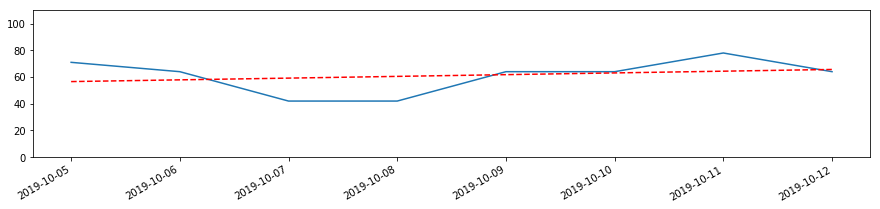

In [10]:
from IPython.core.display import display, HTML
display(HTML(days_html+months_html+statistics_html))
plt.show(dq.display_last_n_months_line_chart())